# Individual zipcode power readings data preprocessing

Here we will undergo data processing for a single site. Here we have Stanford's data. This should be run separately from aggregated sites

## Timestamp alignment and PV components pivoting

In [1]:
#specify data source 
datasource = 'Stanford'

In [35]:
totalsize = 6000

In [42]:
#specify zipcode (along with latitude, longitue, and timezone).
#[zipcode, latitude, longitude, localtz] = ['08640', 40.0039, -74.6178, 'US/Eastern']
#[zipcode, latitude, longitude, localtz] = ['08641', 40.0449, -74.5892, 'US/Eastern']
#[zipcode, latitude, longitude, localtz] = ['92562', 33.5686, -117.2530, 'US/Pacific']
#[zipcode, latitude, longitude, localtz] = ['92563', 33.5712, -117.1540, 'US/Pacific']
[zipcode, latitude, longitude, localtz] = ['94305',37.4270, -122.1650, 'US/Pacific']

In [3]:
#import required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
#from datetime import datetime, tzinfo, dat
import datetime
#from pytz import timezone
import pytz
from pytz import timezone
import pickle #for quick read/write list

#plotting in Notebook
%matplotlib inline

In [5]:
#mainDir = 'C:/Users/Tee/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis\PVreadingsStudies\main'
directory = mainDir + '/data/'+datasource+'/'+zipcode

#No need for metadata
#metadata = pd.read_csv(mainDir+ '/data/' + datasource +'/' + zipcode +'/metadata.csv',
#                             dtype={'componentId':'object','zip':'object'})
#preserve raw metadata. We will modify it later

#metadata.to_csv(directory+"/metadata_original.csv",index=False)
#timeseriesdata = pd.read_csv(mainDir+ '/data/' + datasource +'/'+ zipcode+'/timeseriesdata.csv',
#                             dtype={'componentId':'object'})

data = pd.read_csv(mainDir+'/data/'+ datasource +'/' + zipcode + '/timeseriesdata.csv')
data['tsLocal'] = data['Timestamp'].map(lambda x: datetime.datetime.strptime(x,"%m/%d/%Y %H:%M").strftime("%Y-%m-%d %H:%M:%S"))
#data['tsLocal']=data['LocalTime']
data['power']=data['watts'].map(lambda x: float(x.replace(',', '')))

In [30]:
#No need for adjustment since we have one minute data
#minute adjustment to be 00,15,30 or 45#
#timeseriesdata['tsUTC'] = timeseriesdata['tsUTC'].map(lambda x: x[0:14] + str((int(x[14:16])/15)*15).zfill(2) + ":00")

In [17]:
data[:1]

,Timestamp,unixTS,Value,watts,tsLocal,power
0,12/31/2012 20:57,1357016220,68.29,20.01,2012-12-31 20:57:00,20.01


In [18]:
dat = data.drop(['unixTS','Timestamp','Value','watts'],axis=1)

In [19]:
dat[:1]

,tsLocal,power
0,2012-12-31 20:57:00,20.01


Note that know we don't have any component ID as we have a single component.

C:\Users\Admin\Anaconda\lib\site-packages\pandas\core\generic.py:1974: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


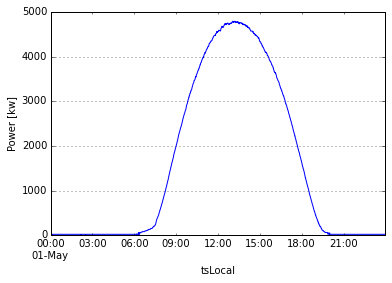

In [22]:
DateOfInterest = "2013-05-01"
df = dat[dat.tsLocal.map(lambda x: x[0:10] == DateOfInterest)]
df.tsLocal = df.tsLocal.map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
df.set_index('tsLocal',inplace=True)
df.plot(legend=False)
plt.ylabel('Power [kw]')

Here is a quick look of number of readings in the day of interest (expect $24 \times 60 = 1440$) and number of components in the zipcode (from dat).

In [23]:
df.shape

(1440, 1)

## The first time stamp identification and data sorting

We don't need fancy sorting for a single site.

In [24]:
dat.sort(['tsLocal'], ascending = [1], inplace=True)
#dat.set_index('tsLocal',inplace=True)

## Scope and sun's altitude selection

Here we would like to data selection based on altitude of the sun. Here we coonstruct a data table with timestamp span matches our data set. This table should contain sun's altitude and azimuth angle. We may merge this table to our data table and select  only readings when the sun is up (altitude $>0$).

In [27]:
dat['tsLocal'][0],dat['tsLocal'][dat.shape[0]-1]

('2012-12-31 20:57:00', '2013-06-03 11:27:00')

In [28]:
#specify scope
StartScopeDate = '2013-01-01'
EndScopeDate = '2015-06-01'
StartScopeTime =  datetime.datetime.strptime(StartScopeDate,"%Y-%m-%d")
EndScopeTime =  datetime.datetime.strptime(EndScopeDate,"%Y-%m-%d")

Note: we now have 1 minute data.

In [31]:
#Generate data frame from start to end, along with altitude and azimuth
tslist = []
nxt = StartScopeTime
while nxt < EndScopeTime:
    tslist.append(nxt)
    nxt += datetime.timedelta(minutes=1)
    
Scope = pd.DataFrame(0, index = np.arange(len(tslist)), columns = ['tsLocal','altitude','azimuth'])
Scope['tsLocal'] = tslist

#need to install Pysolar in command prompt 'pip install Pysolar' first
import Pysolar
Scope['altitude'] = Scope.tsLocal.map(lambda x: Pysolar.GetAltitude(latitude, longitude, 
                                                                    timezone(localtz).localize(x).astimezone(pytz.utc)))

#Consider only when the sun's altitude is high.
Scope = Scope[Scope.altitude>0]
Scope['azimuth'] = Scope.tsLocal.map(lambda x: Pysolar.GetAzimuth(latitude, longitude, 
                                                                    timezone(localtz).localize(x).astimezone(pytz.utc)))
#covert to string to easy handling
Scope['tsLocal'] = Scope.tsLocal.map(lambda x: x.strftime("%Y-%m-%d %H:%M:%S")) 


In [32]:
#Now we can merge using Scope Table as a backbone of data structure.
data = pd.merge(Scope,dat,on=['tsLocal'], how = 'left') 

Now $\texttt{data}$ contains power readings. The rows represent all time stamps in 1 minutes while sun is up for all days of interest. The columns (except for time stamp, azimuth, and altitudes) represent all functioning components in the system. In this case we have only one component.

To make the format consistent, we will add extra two columns to match the case of multiple components

In [36]:
data['numactivecomp']=1
data['totalsize'] = 6000

In [37]:
data['power'] = data['power']/data['totalsize']

In [38]:
data[:1]

,tsLocal,altitude,azimuth,power,numactivecomp,totalsize
0,2013-01-01 07:25:00,0.009829,-298.94417,0.005003,1,6000


Let's save data table and metadata. 

In [44]:
directory = mainDir + '/data/' + datasource +'/' + zipcode
#metadata.to_csv(directory+"/metadata.csv",index=False)
#data.to_csv(directory+"/data.csv",index=False)

In [45]:
data[['tsLocal','altitude','azimuth','power','numactivecomp','totalsize']].to_csv(directory+"/training_data.csv",index=False)